In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import lasso_path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

This MALDI-TOF dataset consists in:
A) A reference panel of 20 Gram positive and negative bacterial species covering 9 genera among which several species are known to be hard to discriminate by mass spectrometry (MALDI-TOF). Each species was represented by 11 to 60 mass spectra obtained from 7 to 20 bacterial strains, constituting altogether a dataset of 571 spectra obtained from 213 strains. The spectra were obtained according to the standard culture-based workflow used in clinical routine in which the microorganism was first grown on an agar plate for 24 to 48 hours, before a portion of colony was picked, spotted on a MALDI slide and a mass spectrum was acquired. 

*Input Pure Spectra*

In [4]:
df_pure_spectra_matrix = pd.read_csv('pure_spectra_matrix.csv', delimiter=';')
print(df_pure_spectra_matrix.head())
print(len(df_pure_spectra_matrix))

   0  0.1  0.2  0.3  0.4  0.5  44431.921875  0.6  0.7  0.8   ...    \
0  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
1  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
2  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     
3  0    0  0.0  0.0  0.0    0   4701.712402  0.0  0.0  0.0   ...     
4  0    0  0.0  0.0  0.0    0      0.000000  0.0  0.0  0.0   ...     

         0.1217  0.1218  0.1219  0.1220        0.1221  0.1222  0.1223  0.1224  \
0  27667.777344     0.0       0     0.0  35438.351562     0.0     0.0     0.0   
1  59820.968750     0.0       0     0.0   6384.590820     0.0     0.0     0.0   
2      0.000000     0.0       0     0.0      0.000000     0.0     0.0     0.0   
3   3913.969727     0.0       0     0.0      0.000000     0.0     0.0     0.0   
4      0.000000     0.0       0     0.0      0.000000     0.0     0.0     0.0   

   0.1225  0.1226  
0     0.0     0.0  
1     0.0     0.0  
2     0.0     0.0  
3     0.0   

*Check Pure Spectra Metadata*

In [5]:
df_pure_spectra_metadata = pd.read_csv('pure_spectra_metadata.csv', delimiter=';')
print(df_pure_spectra_metadata.head(10))
print(len(df_pure_spectra_metadata))

   Species  Strain
0  RTO.TQH       1
1  BUT.YZE       2
2  BUT.YZE       2
3  BUT.YZE       2
4  BUT.YZE       2
5  VVJ.KSF       3
6  VVJ.KSF       3
7  VVJ.KSF       3
8  VVJ.KSF       3
9  VVJ.KSF       4
571


*Input Mixed Spectra Metadata and Check*

In [6]:
df_mixed_spectra_metadata = pd.read_csv('mixed_spectra_metadata.csv', delimiter=';')
print(df_mixed_spectra_metadata)
print(len(df_mixed_spectra_metadata))

    Mixture_Label  Mixture_Id Species_1  Strain_1 Species_2  Strain_2  \
0               A           1   NYV.XSY       214   NYV.VCE        77   
1               A           1   NYV.XSY       214   NYV.VCE        77   
2               A           1   NYV.XSY       214   NYV.VCE        77   
3               A           1   NYV.XSY       214   NYV.VCE        77   
4               A           1   NYV.XSY       214   NYV.VCE        77   
5               A           1   NYV.XSY       214   NYV.VCE        77   
6               A           1   NYV.XSY       214   NYV.VCE        77   
7               A           1   NYV.XSY       214   NYV.VCE        77   
8               A           1   NYV.XSY       214   NYV.VCE        77   
9               A           1   NYV.XSY       214   NYV.VCE        77   
10              A           1   NYV.XSY       214   NYV.VCE        77   
11              A           1   NYV.XSY       214   NYV.VCE        77   
12              A           1   NYV.XSY       214  

B) Based on this reference panel, a dedicated in vitro mock-up mixture dataset was constituted. For that purpose we considered 10 pairs of species of various taxonomic proximity:
* 4 mixtures, labelled A, B, C and D, involved species that belong to the same genus,
* 2 mixtures, labelled E and F, involved species that belong to distinct genera, but to the same Gram type,
* 4 mixtures, labelled G, H, I and J, involved species that belong to distinct Gram types.
Each mixture was represented by 2 pairs of strains, which were mixed according to the following 9 concentration ratios : 1:0, 10:1, 5:1, 2:1, 1:1, 1:2, 1:5, 1:10, 0:1. Two replicate spectra were acquired for each concentration ratio and each couple of strains, leading altogether to a dataset of 360 spectra, among which 80 are actually pure sample spectra.

*Input Mixed Spectra and Check*

In [7]:
df_mixed_spectra_matrix = pd.read_csv('mixed_spectra_matrix.csv', delimiter=';', header=None)
print(df_mixed_spectra_matrix.head(360))
print(len(df_mixed_spectra_matrix))

     0     1           2     3     4     5     6             7     \
0       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
1       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
2       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
3       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
4       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
5       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
6       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
7       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
8       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
9       0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
10      0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
11      0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
12      0   0.0        0.00   0.0   0.0     0   0.0      0.000000   
13      0   0.0        0.00   0.0 

*Input Mixed Spectra*

In [8]:
df_mixed_spectra_metadata = pd.read_csv('mixed_spectra_metadata.csv', delimiter=';')
print(df_mixed_spectra_metadata.head(20))
print(len(df_mixed_spectra_metadata))

   Mixture_Label  Mixture_Id Species_1  Strain_1 Species_2  Strain_2  \
0              A           1   NYV.XSY       214   NYV.VCE        77   
1              A           1   NYV.XSY       214   NYV.VCE        77   
2              A           1   NYV.XSY       214   NYV.VCE        77   
3              A           1   NYV.XSY       214   NYV.VCE        77   
4              A           1   NYV.XSY       214   NYV.VCE        77   
5              A           1   NYV.XSY       214   NYV.VCE        77   
6              A           1   NYV.XSY       214   NYV.VCE        77   
7              A           1   NYV.XSY       214   NYV.VCE        77   
8              A           1   NYV.XSY       214   NYV.VCE        77   
9              A           1   NYV.XSY       214   NYV.VCE        77   
10             A           1   NYV.XSY       214   NYV.VCE        77   
11             A           1   NYV.XSY       214   NYV.VCE        77   
12             A           1   NYV.XSY       214   NYV.VCE      

*Train model and Predict with X_train and X_test*

In [9]:
X_train = df_pure_spectra_matrix
y_train = df_pure_spectra_metadata["Strain"][0:570]
X_test = df_mixed_spectra_matrix
enc = OneHotEncoder(sparse=False)
y_train_reshape = y_train.as_matrix(columns=None)
y_train_reshape = y_train_reshape.reshape(-1, 1)
Y_transform = enc.fit_transform(y_train_reshape)

#print(y_train)
print("Transformed y_train to onehot encoding")
print(Y_transform)

Transformed y_train to onehot encoding
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


Instantiate a Lasso regressor, fit the training data, and predict y_train

In [10]:
# Instantiate a lasso regressor: lassoreg
lassoreg = Lasso(normalize=True, positive=True, alpha = .00000001)

# Fit the regressor to the data
lassoreg.fit(X_train,Y_transform)

# Compute the coefficients
lassoreg_coef = lassoreg.coef_

#print(lassoreg_coef)
y_pred_train = lassoreg.predict(X_train)
print("y_pred_train")
print(y_pred_train)

/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


y_pred_train
[[ 8.30298695e-01  4.42669551e-01  4.39095091e-02 ... -1.24412997e-03
  -2.17753081e-03 -2.77744697e-07]
 [ 2.44519689e-01  5.10904142e-01  3.34418668e-02 ...  1.28621956e-03
   8.55609257e-03 -1.33166518e-06]
 [ 5.62589739e-02  1.01389841e+00  8.99312468e-03 ...  3.05314393e-03
  -2.37899691e-04 -1.27037067e-06]
 ...
 [-3.18936083e-04 -1.05643008e-03  2.38492727e-02 ...  3.48797322e-02
   3.53476435e-01 -9.86329991e-07]
 [-6.94773927e-03 -2.94531871e-03 -5.17951044e-03 ... -2.38260871e-02
   2.43548888e-01  5.75965448e-06]
 [ 2.02333857e-02  4.38370445e-03  3.70915164e-02 ...  5.25019606e-02
   2.51612828e-01  9.99993201e-01]]


Display bacteria strain predicted from X_train, indicate matches with Y_transform

In [11]:
print("Predicted bacteria strain from pure spectra using Lasso regression")
print(y_pred_train.argmax(axis=1) + 1)

print("Matches of strain predicted for training using Lasso Regression and actual for each sample:")
print((y_train-1)==y_pred_train.argmax(axis=1))

Predicted bacteria strain from pure spectra using Lasso regression
[  1   2   2   2  75   3   7   3   3   4   4   3   5   5   6   6   7  23
   7   7   7 200 200   9   9  54  10  10  11  12  12  12  13 144  14  14
  14  15  15  15 138  16  16  17  17 172  18  18 105  18  19  20  21 136
  21  21  21  22  22 151  23  23   2  58  24  58 210  25  25  26  26  26
  26  27  27  27  27  29  29  29  29  29  30  31  31 126  31  32  33  33
  34  34  35  35  35  35  36  36  37  38  38  39  39  40  40  41  41  41
  41  42  42  42  43  42  43  44  44  44 131  45  46  46  47  47  47  47
  48  48  49  49  49  49  49 156  50  51  51  51  51  51  52 175  52  53
  53  53  54  54  54  55  55  56  56  56  56  57 107  57 212  58  58  58
  54  59  58  59  60  61   4  62  62  62  63  63  63  63  64  64  66  66
  66  66  66  66  66  67 155 155  68  69  69  69  69  70  70  70  71  72
  72  72  73  73  74  74  74  74  74  74  76  76  76  76  77  77  77  77
  77  78  78  79  80  80  81  82  82  83  84  84  84  84 

Predict strain from mixtures stored in X_test

In [12]:
print("Predict strain from X_test using Lasso Regression:")
y_pred_test = lassoreg.predict(X_test)

print("y_pred_test")
print(y_pred_test)

#print("The length of y_pred_test is: " + str(len(y_pred_test)))

print("The predicted strain in the mixture for each sample is:")
print(y_pred_test.argmax(axis=1))

#print("The length of the mixed spectra metadata is: " + str(len(df_mixed_spectra_metadata)))
#print(df_mixed_spectra_metadata.head(360))

#print((y_pred_test-1)==df_mixed_spectra_metadata['Strain_1'][1:] or (y_pred_test-1)==df_mixed_spectra_metadata['Strain_2'][1:])

Predict strain from X_test using Lasso Regression:
y_pred_test
[[-3.54105858e-03  2.07051236e-02 -1.41621331e-02 ...  9.30668514e-02
  -1.33970119e-02 -1.31847991e-06]
 [-4.96081927e-03 -9.49802591e-04  2.17974639e-03 ...  2.46606648e-02
  -1.90907473e-02 -1.35933957e-06]
 [-4.72325945e-03  1.18870757e-02 -1.74076267e-02 ...  4.90908744e-02
  -1.91644865e-02 -1.05491576e-06]
 ...
 [-2.13217119e-03 -4.50156877e-03 -5.69906899e-03 ...  1.44853406e-02
  -1.39162693e-02 -4.77898695e-07]
 [-6.27360351e-03 -5.33423730e-03 -8.14871526e-03 ...  2.49678463e-02
  -1.73202777e-02 -1.04578752e-06]
 [ 1.07972554e-03 -2.79618589e-03  3.13653983e-03 ...  1.25058208e-02
  -1.36625185e-02 -1.04996832e-06]]
The predicted strain in the mixture for each sample is:
[136 136 115 115 115 136 156 115  62  62  62  62  52  62 136  62  62  62
 156 156 179 179 179  68  14 156  62  14  62  62 149  62  52  62  62  52
  41 172  41 211  41  41  41  12  47 211  47  47  47  47  47  46 211  47
 121 143  54 143 143 121 1

Logistic Regression

In [13]:
X_train = df_pure_spectra_matrix
y_train = df_pure_spectra_metadata["Strain"][0:570]
X_test = df_mixed_spectra_matrix
y_train = y_train.astype('category')

# Instantiate a lasso regressor: lassoreg
logreg = LogisticRegression(penalty='l1')

# Fit the regressor to the data
logreg.fit(X_train,y_train)

#print(lassoreg_coef)
print(y_train)
y_pred_train = logreg.predict(X_train)
print(y_pred_train)
y_pred_test = logreg.predict(X_test)
print(y_pred_test)
print(df_mixed_spectra_metadata[:])

0        1
1        2
2        2
3        2
4        2
5        3
6        3
7        3
8        3
9        4
10       4
11       5
12       5
13       5
14       6
15       6
16       7
17       7
18       7
19       7
20       7
21       7
22       8
23       8
24       9
25       9
26      10
27      10
28      11
29      12
      ... 
540    202
541    202
542    202
543    202
544    203
545    203
546    204
547    205
548    206
549    206
550    206
551    206
552    207
553    207
554    208
555    208
556    209
557    209
558    210
559    210
560    211
561    211
562    211
563    211
564    211
565    212
566    212
567    212
568    212
569    213
Name: Strain, Length: 570, dtype: category
Categories (213, int64): [1, 2, 3, 4, ..., 210, 211, 212, 213]
[  1   2   2   2   2   3   3   3   3   4   4   5   5   5   6   6   7   7
   7   7   7   7   8   8   9   9  10  10  11  12  12  12  13  14  14  14
  14  15  15  15  15  16  16  17  17  17  18  18  18  18  19  20  20  21
  21

0        1
1        2
2        2
3        2
4        2
5        3
6        3
7        3
8        3
9        4
10       4
11       5
12       5
13       5
14       6
15       6
16       7
17       7
18       7
19       7
20       7
21       7
22       8
23       8
24       9
25       9
26      10
27      10
28      11
29      12
      ... 
540    202
541    202
542    202
543    202
544    203
545    203
546    204
547    205
548    206
549    206
550    206
551    206
552    207
553    207
554    208
555    208
556    209
557    209
558    210
559    210
560    211
561    211
562    211
563    211
564    211
565    212
566    212
567    212
568    212
569    213
Name: Strain, Length: 570, dtype: int64


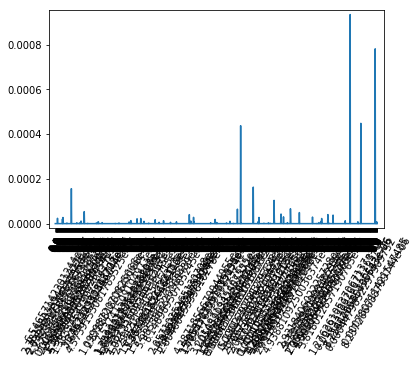

[103.0165329   96.04936009  99.90533608  98.18292289 104.54330692
  97.72617603 113.79473873  97.54578955  96.90758632  93.97159011
  95.81933632  97.26065014  92.28744174 101.90882579  96.1715834
  92.66200126  97.29053898  90.72815646 143.5513582  119.89077524
 102.14316914 102.02360247  99.52151644 100.35620322 110.17952641
 139.21478738 100.66996627  96.33098731  97.30898805 100.34665117
 106.39310181  95.65162312  97.19468118  97.6259265   94.08639541
  96.04827132  88.20577494  89.14805361  90.05592015  90.00075508
  88.76370488  89.55738094  88.89937712  89.07276349  90.47330949
  89.75282265  91.63678363  91.55055958  92.35264713  90.92085275
  90.33612963  90.04113928  90.37632784  98.10452481  89.36096677
  90.01137629  91.77427405  90.31668721  89.27017539  90.97370443
  90.76150973  90.26908261  88.84196041  89.36308411  88.57634984
  88.28868805  88.58908292  89.10996182  93.63570981  88.58155413
  92.81971488  94.36655754 141.71948841 200.35095283 135.90122903
 154.840124

In [14]:
X_train = df_pure_spectra_matrix
y_train = df_pure_spectra_metadata["Strain"][0:570]
X_test = df_mixed_spectra_matrix

print(y_train)

# Instantiate a lasso regressor: lassoreg
lassoreg = Lasso(normalize=True, positive=True, alpha = .1)

# Fit the regressor to the data
lassoreg.fit(X_train,y_train)

# Compute the coefficients
lassoreg_coef = lassoreg.coef_
#print(lassoreg_coef)
y_pred_train = lassoreg.predict(X_train)
#print(y_pred_train)
y_pred_test = lassoreg.predict(X_test)
#print(y_pred_test)

# Plot the coefficients
plt.plot(range(len(lassoreg_coef)), lassoreg_coef)
plt.xticks(range(len(lassoreg_coef)), lassoreg_coef, rotation=60)
plt.margins(0.02)
plt.show()

# Plot the y_pred_test
# plt.plot(range(len(y_pred_test)), y_pred_test)
# plt.xticks(range(len(y_pred_test)), y_pred_test, rotation=60)
# plt.margins(0.02)
# plt.show()

print(y_pred_test)

# Import Lasso
#from sklearn.linear_model import Lasso

# Instantiate a lasso regressor: lasso
#lasso = Lasso(alpha = 0.4, normalize = True)

# Fit the regressor to the data
#lasso.fit(X, y)

# Compute and print the coefficients
#lasso_coef = lasso.coef_
#print(lasso_coef)

# Plot the coefficients
#plt.plot(range(len(df_columns)), lasso_coef)
#plt.xticks(range(len(df_columns)), df_columns.values, rotation=60)
#plt.margins(0.02)
#plt.show()

In [16]:
_, coef_path, _ = lasso_path(X_train,y_train,max_iter=1,positive=True)
print(coef_path)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.51461147e-07
  1.09810153e-06 2.56818048e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


*Calculate Length of y_pred_train and y_pred_test*

In [17]:
print(len(y_pred_train))
print(len(y_pred_test))

570
360


*Evaluate test data*

In [18]:
X_train = [[0, 2],[2,0]]
y_train = pd.Series([1, 2])
X_test = [[0, 2], [2, 0]]
y_train = y_train.astype('category')

lassoreg = Lasso(positive=True, alpha = 0.001, normalize=True)
lassoreg.fit(X_train,y_train)
#y_pred_train = lassoreg.predict(X_train)
#print(y_pred_train)
y_pred_test = lassoreg.predict(X_test)
print(y_pred_test)

[1.00141421 1.99858579]


In [19]:
X_train = [[0, 2],[2,0]]
y_train = pd.Series(["a", "b"])
X_test = [[0, 2], [2, 0]]
y_train = y_train.astype('category')

logreg = LogisticRegression(penalty='l1')
logreg.fit(X_train,y_train)
#y_pred_train = lassoreg.predict(X_train)
#print(y_pred_train)
y_pred_test = logreg.predict(X_test)
print(y_pred_test)
y_pred = logreg.predict_proba(X_test)
print(y_pred)

['a' 'a']
[[0.5 0.5]
 [0.5 0.5]]


In [20]:
X_train = df_pure_spectra_matrix
y_train = df_pure_spectra_metadata["Strain"][0:570]
X_test = df_mixed_spectra_matrix
enc = OneHotEncoder(sparse=False)
y_train_reshape = y_train.as_matrix(columns=None)
y_train_reshape = y_train_reshape.reshape(-1, 1)
Y_transform = enc.fit_transform(y_train_reshape)

# Instantiate a lasso regressor: lassoreg
logreg = LogisticRegression(penalty='l1')

# Fit the regressor to the data
logreg.fit(X_train,y_train)

#print(lassoreg_coef)
print(y_train)
y_pred_train = logreg.predict(X_train)
print(y_pred_train)
y_pred_test = logreg.predict(X_test)
print(y_pred_test)
print(df_mixed_spectra_metadata[:])

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


0        1
1        2
2        2
3        2
4        2
5        3
6        3
7        3
8        3
9        4
10       4
11       5
12       5
13       5
14       6
15       6
16       7
17       7
18       7
19       7
20       7
21       7
22       8
23       8
24       9
25       9
26      10
27      10
28      11
29      12
      ... 
540    202
541    202
542    202
543    202
544    203
545    203
546    204
547    205
548    206
549    206
550    206
551    206
552    207
553    207
554    208
555    208
556    209
557    209
558    210
559    210
560    211
561    211
562    211
563    211
564    211
565    212
566    212
567    212
568    212
569    213
Name: Strain, Length: 570, dtype: int64
[  1   2   2   2   2   3   3   3   3   4   4   5   5   5   6   6   7   7
   7   7   7   7   8   8   9   9  10  10  11  12  12  12  13  14  14  14
  14  15  15  15  15  16  16  17  17  17  18  18  18  18  19  20  20  21
  21  21  21  22  22  22  23  23  23  24  24  24  24  25  25  26  26  

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=True, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.037721
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.240498


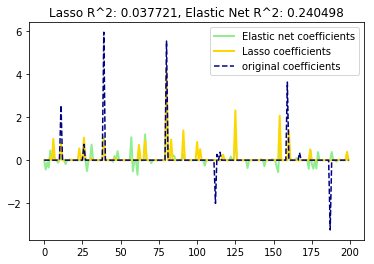

In [21]:
# Generate some sparse data to play with
np.random.seed(42)

n_samples, n_features = 50, 200
X = np.random.randn(n_samples, n_features)
coef = 3 * np.random.randn(n_features)
inds = np.arange(n_features)
np.random.shuffle(inds)
coef[inds[10:]] = 0  # sparsify coef
y = np.dot(X, coef)

# add noise
y += 0.01 * np.random.normal(size=n_samples)

# Split data in train set and test set
n_samples = X.shape[0]
X_train, y_train = X[:n_samples // 2], y[:n_samples // 2]
X_test, y_test = X[n_samples // 2:], y[n_samples // 2:]

# #############################################################################
# Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha, positive=True)

y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

# #############################################################################
# ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

plt.plot(enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
plt.plot(coef, '--', color='navy', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()